### CNN classification - detecting the moment before rain

**This code is at least partially usable, however needs more testing.**

This is a rough sketch how CNN classification could be used here to detect the moment before something happens (like rain).

IDEAS to try:

Try sampling techniques in order to balance rain/no rain in training dataset.

You can also try class_weights to penalize missing rain in the model fit. (this was tried here with farily good success!)

Might be a good idea to combine multiple data files in order to get more training data here..

**Note: this example is using the rain data as both the target (simplified to 0 and 1) and a support variable. This is partial target leakage just to see if this model works at all or not. In actual systems, we want to use something else as the support variable.**

In [123]:
# pip install tensorflow
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# pip install seaborn
import seaborn as sns
import tensorflow as tf

import os

# for random seed lock later
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"  
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" 

# if your Jupyter kernel crashes during this code, use this setting
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# lock down random seed
SEED = 784321


random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


**NOTE: instead of the usual 1 hour interval, this one uses 15 min interval data from Open Meteo**

In [124]:
# using a CSV snapshot from autumn 2022 in Saaritie, Jyväskylä

# load data snapshot and rename columns
df = pd.read_csv("open-meteo-66.51N25.73E92m.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.rename(columns={"time": "Timestamp"})
df = df.dropna(axis=1)

df.head(3)

,Timestamp,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),wind_gusts_10m (km/h),visibility (m),cape (J/kg),is_day (),rain (mm),snowfall (cm),freezing_level_height (m),weather_code (wmo code),wind_speed_10m (km/h),wind_speed_80m (km/h),wind_direction_10m (°),wind_direction_80m (°)
0,2024-01-01 00:00:00,-22.1,81,-24.5,-26.6,0.0,5.8,19480.0,0.0,0,0.0,0.0,-1120.0,0,3.2,14.2,126,83
1,2024-01-01 00:15:00,-22.4,81,-24.7,-26.8,0.0,5.8,18820.0,0.0,0,0.0,0.0,-1130.0,0,3.2,13.8,124,84
2,2024-01-01 00:30:00,-22.6,81,-25.0,-27.1,0.0,5.8,18160.0,0.0,0,0.0,0.0,-1150.0,0,3.6,13.8,121,84


In [125]:
# for CNN, let's replace the timestamp with a sequence number
df['sequence'] = df.index + 1
df = df.drop(['Timestamp'], axis=1)

In [126]:
df.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'precipitation (mm)',
       'wind_gusts_10m (km/h)', 'visibility (m)', 'cape (J/kg)', 'is_day ()',
       'rain (mm)', 'snowfall (cm)', 'freezing_level_height (m)',
       'weather_code (wmo code)', 'wind_speed_10m (km/h)',
       'wind_speed_80m (km/h)', 'wind_direction_10m (°)',
       'wind_direction_80m (°)', 'sequence'],
      dtype='object')

In [127]:
# let's choose a few random additional columns that most likely are related to rain
cols = ['sequence', 'relative_humidity_2m (%)', 'precipitation (mm)', 'wind_speed_10m (km/h)']
df = df[cols]

In [128]:
df

,sequence,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h)
0,1,81,0.0,3.2
1,2,81,0.0,3.2
2,3,81,0.0,3.6
3,4,80,0.0,3.6
4,5,80,0.0,4.0
...,...,...,...,...
35131,35132,87,0.0,9.4
35132,35133,87,0.0,9.0
35133,35134,87,0.0,8.6
35134,35135,88,0.0,8.3


In [129]:
# it seems we have some missing data
# with time series you usually would want to handle these
# gaps carefully in order to preserve trends
# but for this demonstration we are going to remove them
df.isna().sum()

sequence                    0
relative_humidity_2m (%)    0
precipitation (mm)          0
wind_speed_10m (km/h)       0
dtype: int64

In [130]:
df

,sequence,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h)
0,1,81,0.0,3.2
1,2,81,0.0,3.2
2,3,81,0.0,3.6
3,4,80,0.0,3.6
4,5,80,0.0,4.0
...,...,...,...,...
35131,35132,87,0.0,9.4
35132,35133,87,0.0,9.0
35133,35134,87,0.0,8.6
35134,35135,88,0.0,8.3


<b>Let's create our target based on the friction values</b>

In [131]:
# for simplicity, let's just have two target categories,
# 0 and 1 => no rain / yes rain
def create_target_value(row):
    # if rain intensity is above 0 => target 1 (yes)
    if row['precipitation (mm)'] > 0:
        return 1
    else:
        return 0
    
df['target'] = df.apply(create_target_value, axis=1)

In [132]:
df

,sequence,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),target
0,1,81,0.0,3.2,0
1,2,81,0.0,3.2,0
2,3,81,0.0,3.6,0
3,4,80,0.0,3.6,0
4,5,80,0.0,4.0,0
...,...,...,...,...,...
35131,35132,87,0.0,9.4,0
35132,35133,87,0.0,9.0,0
35133,35134,87,0.0,8.6,0
35134,35135,88,0.0,8.3,0


In [133]:
# quite unbalanced
df['target'].value_counts()

target
0    31252
1     3884
Name: count, dtype: int64

<b>Let's "rewind" the target variable for 2 hours (12 steps, since 1 step is 15min => 12 * 15min => 180 min => 3 hours</b>

In [134]:
# "rewind" the target variable, so we are actually going to 
# predict the future situation with this model
df['target'] = df['target'].shift(periods=-12)

In [135]:
df

,sequence,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),target
0,1,81,0.0,3.2,0.0
1,2,81,0.0,3.2,0.0
2,3,81,0.0,3.6,0.0
3,4,80,0.0,3.6,0.0
4,5,80,0.0,4.0,0.0
...,...,...,...,...,...
35131,35132,87,0.0,9.4,NaN
35132,35133,87,0.0,9.0,NaN
35133,35134,87,0.0,8.6,NaN
35134,35135,88,0.0,8.3,NaN


In [136]:
# remove NaNs, there are some missing values already
# in the dataset, but we also introduced 12 new NaN values into the 
# end of the dataset (since we rewound the data)
df = df.dropna()
df

,sequence,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),target
0,1,81,0.0,3.2,0.0
1,2,81,0.0,3.2,0.0
2,3,81,0.0,3.6,0.0
3,4,80,0.0,3.6,0.0
4,5,80,0.0,4.0,0.0
...,...,...,...,...,...
35119,35120,89,0.0,10.4,0.0
35120,35121,90,0.0,10.4,0.0
35121,35122,90,0.0,10.4,0.0
35122,35123,90,0.0,10.4,0.0


<b>Visualize a bit...</b>

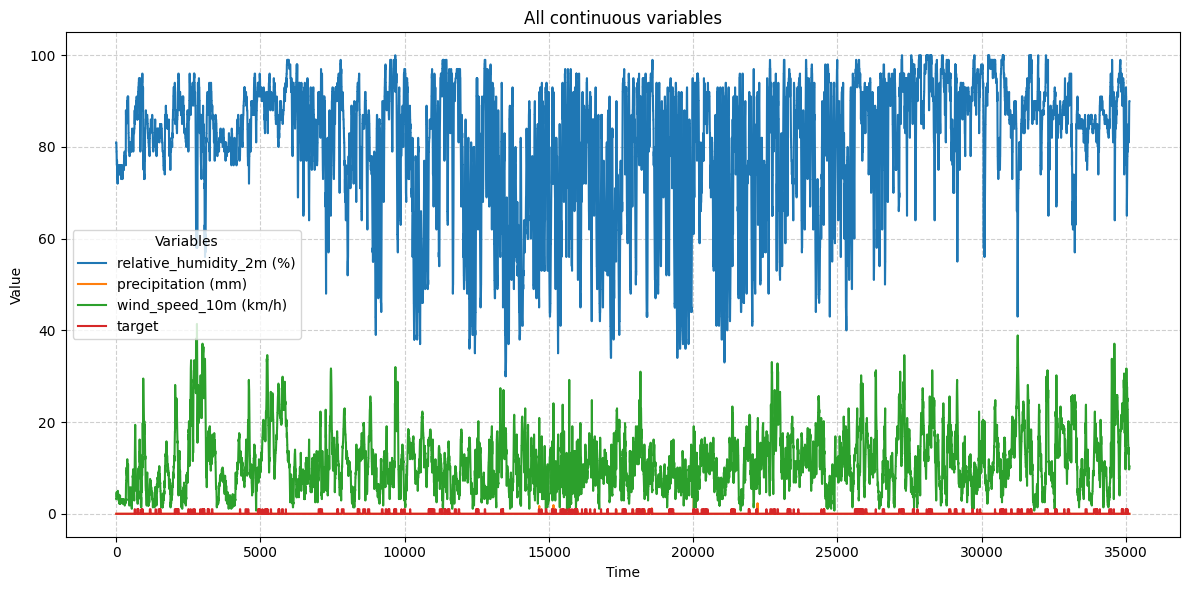

In [137]:
# plot everything we have
df.set_index("sequence", inplace=True)

plt.figure(figsize=(12, 6))

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.title("All continuous variables")
plt.xlabel("Time")
plt.ylabel("Value")

plt.legend(title="Variables")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<b>For CNN, always use a scaler (MinMax)</b>

In [138]:
df.columns

Index(['relative_humidity_2m (%)', 'precipitation (mm)',
       'wind_speed_10m (km/h)', 'target'],
      dtype='object')

In [139]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cols.remove("sequence")

# scale continuous variables
# cols = ['precipitationIntensity_mm_h', 'rain (mm)', 'precipitation (mm)']
df[cols] = scaler.fit_transform(df[cols])

# we need this variable in many places
# this should be 3 at this point
n_features = len(cols)

C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_15172\779665660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = scaler.fit_transform(df[cols])


In [140]:
df

,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),target
sequence,,,,
1,0.728571,0.0,0.061425,0.0
2,0.728571,0.0,0.061425,0.0
3,0.728571,0.0,0.071253,0.0
4,0.714286,0.0,0.071253,0.0
5,0.714286,0.0,0.081081,0.0
...,...,...,...,...
35120,0.842857,0.0,0.238329,0.0
35121,0.857143,0.0,0.238329,0.0
35122,0.857143,0.0,0.238329,0.0


<b>Timestep splitting...</b>

In [141]:
from numpy.lib.stride_tricks import sliding_window_view

# we need to experiment here, probably values between 10-200
timestep_size = 12

# extract sliding windows for support variables, we will use separate timesteps
# no overlap among windows (hence using [::timestep_size])
input_windows = sliding_window_view(df[cols].values, window_shape=(timestep_size, n_features))[::timestep_size]

# target windows
target_windows = sliding_window_view(df['target'].values, window_shape=(timestep_size))[::timestep_size]

# for each timestep window => use the last target variable
# as the target of the whole timestep
targets = target_windows[:, -1]

# reshape inputs to to needed shape (num_windows, timestep_size, n_features)
inputs = input_windows.reshape(-1, timestep_size, 3)

# X/y -variables
X = inputs
y = targets


In [142]:
# this shape looks correct
X.shape

(2927, 12, 3)

In [143]:
# ... and this matches with X.shape
y.shape

(2927,)

<b>Shuffle the data for training</b>

In [144]:
from sklearn.utils import shuffle

# shuffle X/y
X, y = shuffle(X, y, random_state=42)

<b>Train test split</b>

In [145]:
# define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

<b>Make the model</b>

In [146]:
def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # keras.layers.Conv1D(filters=32, kernel_size=3, padding="same"),
            # keras.layers.BatchNormalization(),
            # keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(2, activation="softmax")
        ]
    )

    return model


# make the model
model = make_model(input_shape=x_train.shape[1:])


<b>Configure and train the model</b>

In [147]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_classifier.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)


# technically class_weight here penalizes missing rain detections
# interesting technique!
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1, class_weight={0: 1.0, 1: 10.0}
)

Epoch 1/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2596 - sparse_categorical_accuracy: 0.5427 - val_loss: 0.7518 - val_sparse_categorical_accuracy: 0.1220 - learning_rate: 0.0010
Epoch 2/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.7423 - val_sparse_categorical_accuracy: 0.2000 - learning_rate: 0.0010
Epoch 3/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1585 - sparse_categorical_accuracy: 0.6398 - val_loss: 0.7177 - val_sparse_categorical_accuracy: 0.3439 - learning_rate: 0.0010
Epoch 4/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.6624 - val_loss: 0.6855 - val_sparse_categorical_accuracy: 0.5073 - learning_rate: 0.0010
Epoch 5/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1267 - sparse_categorical_accuracy: 0.6764 - val_loss: 0.6566 - val_sparse_categorical_accuracy: 0.6415 - learning_rate: 0.0010
Epoch 6/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

In [148]:
model = keras.models.load_model("best_model_classifier.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3956 - sparse_categorical_accuracy: 0.8669  
Test accuracy 0.8668941855430603
Test loss 0.3955921530723572


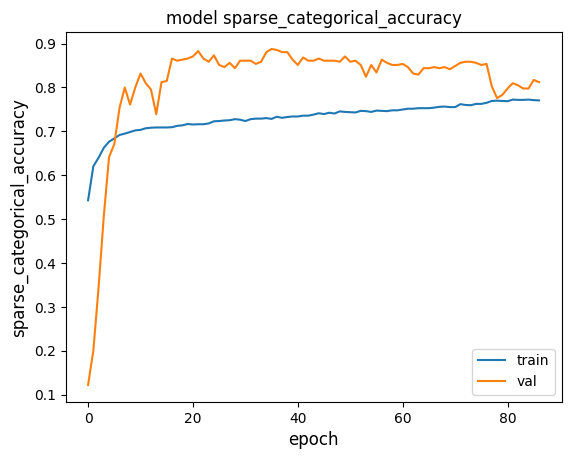

In [149]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

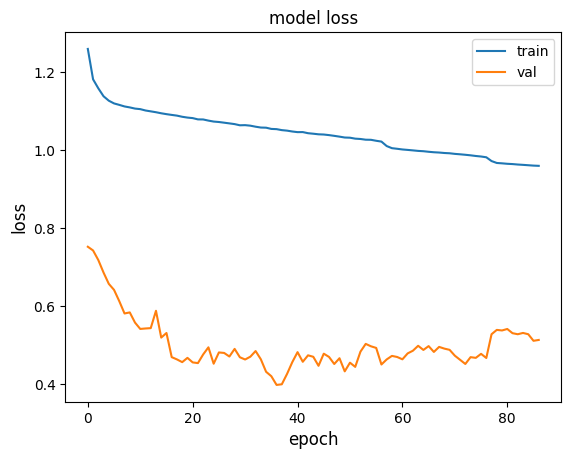

In [150]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [151]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<Axes: >

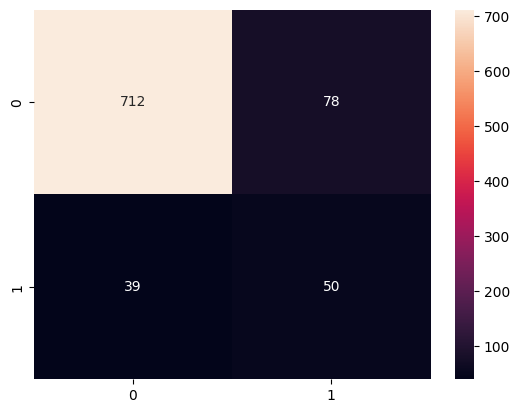

In [152]:

sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# pretty decent, most of the cases of non-slippery
# and slippery was correctly detected

In [153]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92       790
         1.0       0.39      0.56      0.46        89

    accuracy                           0.87       879
   macro avg       0.67      0.73      0.69       879
weighted avg       0.89      0.87      0.88       879


Model overall accuracy: 86.69%


In [154]:
# print the ROC AUC -score
roc_auc_score(y_test, model.predict(x_test)[:, 1])

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.8013511591523254

<b>Find a loop to find test value indexes that SHOULD be detected as slippery</b>

In this part, we try to find an example where classification should be 1 => Raining for comparison.

In [155]:
suitables = []

# loop through the y-values where it should be target == 1
amount = len(y)

for index in range(amount):
    if y[index] == 1:
        print(f"{index} - {y[index]}")
        suitables.append(index)

20 - 1.0
36 - 1.0
39 - 1.0
40 - 1.0
59 - 1.0
74 - 1.0
96 - 1.0
115 - 1.0
133 - 1.0
137 - 1.0
151 - 1.0
155 - 1.0
172 - 1.0
174 - 1.0
191 - 1.0
205 - 1.0
213 - 1.0
248 - 1.0
253 - 1.0
268 - 1.0
271 - 1.0
274 - 1.0
289 - 1.0
292 - 1.0
295 - 1.0
296 - 1.0
308 - 1.0
312 - 1.0
314 - 1.0
319 - 1.0
336 - 1.0
351 - 1.0
361 - 1.0
371 - 1.0
383 - 1.0
385 - 1.0
389 - 1.0
394 - 1.0
432 - 1.0
439 - 1.0
440 - 1.0
447 - 1.0
458 - 1.0
468 - 1.0
470 - 1.0
474 - 1.0
484 - 1.0
486 - 1.0
489 - 1.0
513 - 1.0
514 - 1.0
536 - 1.0
557 - 1.0
558 - 1.0
559 - 1.0
580 - 1.0
585 - 1.0
587 - 1.0
601 - 1.0
604 - 1.0
616 - 1.0
623 - 1.0
625 - 1.0
627 - 1.0
652 - 1.0
658 - 1.0
665 - 1.0
673 - 1.0
682 - 1.0
684 - 1.0
694 - 1.0
700 - 1.0
701 - 1.0
702 - 1.0
706 - 1.0
714 - 1.0
740 - 1.0
745 - 1.0
752 - 1.0
774 - 1.0
804 - 1.0
816 - 1.0
833 - 1.0
839 - 1.0
843 - 1.0
850 - 1.0
854 - 1.0
855 - 1.0
858 - 1.0
862 - 1.0
898 - 1.0
908 - 1.0
912 - 1.0
918 - 1.0
920 - 1.0
937 - 1.0
941 - 1.0
944 - 1.0
973 - 1.0
978 - 1.0
985 - 1

In [156]:
len(suitables)

313

In [157]:
index = 40
y[index]

np.float64(1.0)

In [158]:
# let's browse the correct predictions
for index in suitables:
    test_signal = np.expand_dims(X[index], axis=0)
    test_batch = np.array(test_signal)

    result = model.predict(test_batch, verbose=0)

    # only filter out correct rain predictions
    if result[0][1] > result[0][0]:
        print(result)
        print(index)
        print()

[[0.0953993 0.9046007]]
20

[[0.30244696 0.69755304]]
40

[[0.23016007 0.76983994]]
59

[[0.20005785 0.7999422 ]]
115

[[0.2147173 0.7852827]]
155

[[0.25323188 0.7467681 ]]
172

[[0.3040671  0.69593287]]
174

[[0.10402008 0.89598   ]]
205

[[0.13513903 0.86486095]]
213

[[0.120063536 0.8799364  ]]
248

[[0.02945403 0.97054595]]
296

[[0.19622768 0.8037723 ]]
312

[[0.22442274 0.77557725]]
314

[[0.077113345 0.92288667 ]]
336

[[0.051522475 0.9484775  ]]
351

[[0.1791157  0.82088435]]
371

[[0.12481256 0.87518746]]
383

[[0.45137215 0.54862785]]
385

[[0.056275044 0.943725   ]]
394

[[0.3843879  0.61561215]]
440

[[0.09978686 0.9002131 ]]
458

[[0.18557246 0.8144275 ]]
468

[[0.22799353 0.77200645]]
486

[[0.09951771 0.90048224]]
489

[[0.12083306 0.8791669 ]]
514

[[0.35188165 0.6481184 ]]
536

[[0.2824954 0.7175045]]
557

[[0.1580328  0.84196717]]
559

[[0.06788586 0.9321142 ]]
580

[[0.19231142 0.80768853]]
604

[[0.37824726 0.62175274]]
616

[[0.030428363 0.96957165 ]]
623

[[0.239

C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_15172\3831771975.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


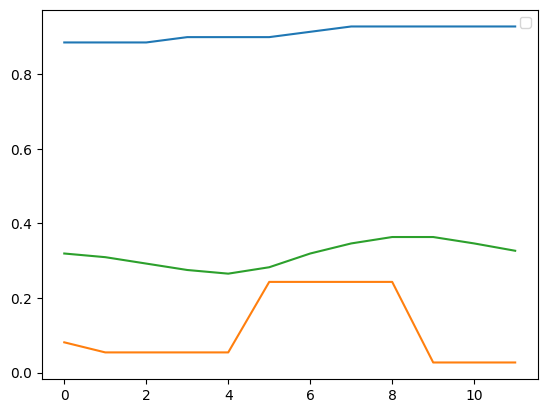

In [159]:
test_signal_index = 205
plt.plot(X[test_signal_index])
plt.legend()

In [160]:
# order is blue, orange, green apparently
# for the variables input into the model
X[test_signal_index]

array([[0.885714285714, 0.081081081081, 0.31941031941 ],
       [0.885714285714, 0.054054054054, 0.309582309582],
       [0.885714285714, 0.054054054054, 0.292383292383],
       [0.9           , 0.054054054054, 0.275184275184],
       [0.9           , 0.054054054054, 0.265356265356],
       [0.9           , 0.243243243243, 0.282555282555],
       [0.914285714286, 0.243243243243, 0.31941031941 ],
       [0.928571428571, 0.243243243243, 0.346437346437],
       [0.928571428571, 0.243243243243, 0.363636363636],
       [0.928571428571, 0.027027027027, 0.363636363636],
       [0.928571428571, 0.027027027027, 0.346437346437],
       [0.928571428571, 0.027027027027, 0.326781326781]])

**Generative AI used heavily to generate test signals that mimic the real case above**

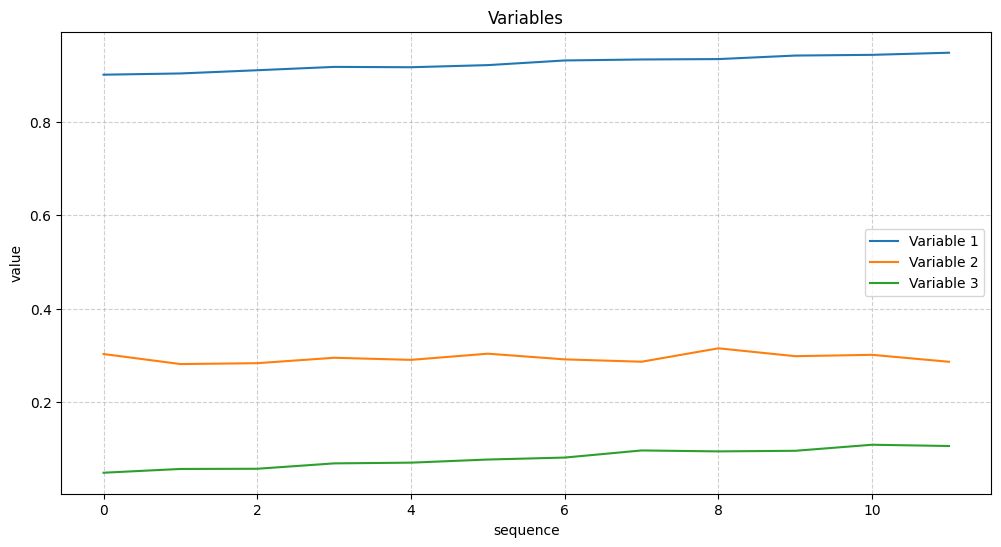

In [161]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

n = 12  # number of samples

# -------------------------
# Variable 1:
# Fluctuates around 0.9, slightly rising toward 0.93
# -------------------------
v1_base = 0.9 + 0.05 * np.linspace(0, 1, n)   # slow rise 0.90 → 0.93
v1_noise = np.random.normal(0, 0.003, n)      # tight fluctuations
x_value = v1_base + v1_noise

# -------------------------
# Variable 2:
# Fluctuates around 0.3
# -------------------------
v2_base = np.ones(n) * 0.30
v2_noise = np.random.normal(0, 0.01, n)       # slightly wider fluctuations
y_value = v2_base + v2_noise

# -------------------------
# Variable 3:
# Fluctuates around 0.05 but rises gradually toward 0.1+ near the end
# -------------------------
v3_base = 0.05 + 0.06 * np.linspace(0, 1, n)  # 0.05 → 0.11 slow rise
v3_noise = np.random.normal(0, 0.004, n)
z_value = v3_base + v3_noise

# -------------------------
# Combine into single array (n × 3)
# -------------------------
data = np.array([x_value, y_value, z_value]).T

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(x_value, label="Variable 1")
plt.plot(y_value, label="Variable 2")
plt.plot(z_value, label="Variable 3")
plt.legend()
plt.title("Variables")
plt.xlabel("sequence")
plt.ylabel("value")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

**It seems to work in principle... however, the data is not very optimal for this**

Generative AI might have ideas on how to create a CNN classifier for rain, however, it might also be highly inconvenient for this kind of data.

In [162]:
np.set_printoptions(precision=12, suppress=True)

In [163]:
test_signal = np.expand_dims(data, axis=0)
test_batch = np.array(test_signal)

result = model.predict(test_batch, verbose=0)

# correctly detected that it's going to be rainy soon 
#  ~~ 87+% confidence
print(result)

[[0.1285426 0.8714574]]
